In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Libraries

In [ ]:

import numpy as np
import pandas as pd 
import os
!pip install librosa
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

Dataset 

CHange the path here

In [ ]:
from sklearn.utils import shuffle

import joblib
X = joblib.load('/content/drive/My Drive/R_Paper/X.joblib')
y = joblib.load('/content/drive/My Drive/R_Paper/y.joblib')
#X = data.drop(data[[67415]], axis=1)
#y=data[[67415]]
X, y = shuffle(X, y)

In [ ]:
 #convert labels into numbers
Y = pd.get_dummies(y).values 
Y.shape

(1600, 10)

In [ ]:
X.shape[1]/2

136.5

Transfomer coding

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask zero out padding tokens.
    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)

    return tf.matmul(attention_weights, value)

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 1,2,3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 1,2,3])

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        outputs = self.dense(concat_attention)

        return outputs

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
# This allows to the transformer to know where there is real data and where it is padded
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout,name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None,d_model ), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(time_steps,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            projection,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
  
    if projection=='linear':
        projection=tf.keras.layers.Dense( d_model,use_bias=True, activation='linear')(inputs)
        print('linear')
  
    else:
        projection=tf.identity(inputs)
        print('none')
   
    projection *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    projection = PositionalEncoding(time_steps, d_model)(projection)

    outputs = tf.keras.layers.Dropout(rate=dropout)(projection)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
            )([outputs, padding_mask])
 
 
  

 
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def transformer(time_steps,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                output_size,
                projection,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,d_model), name="inputs")
  
  
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(tf.dtypes.cast(
          
    #Like our input has a dimension of length X d_model but the masking is applied to a vector
    # We get the sum for each row and result is a vector. So, if result is 0 it is because in that position was masked      
    tf.math.reduce_sum(
    inputs,
    axis=2,
    keepdims=False,
    name=None
), tf.float32))
  

    enc_outputs = encoder(
      time_steps=time_steps,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
      projection=projection,
      name='encoder')(inputs=[inputs, enc_padding_mask])

    #We reshape for feeding our FC in the next step
    outputs=tf.reshape(enc_outputs,(-1,time_steps*d_model))
  
    #We predict our class
    outputs = tf.keras.layers.Dense(units=output_size,use_bias=True,activation='softmax', name="outputs")(outputs)

    return tf.keras.Model(inputs=[inputs], outputs=outputs, name='audio_class')

In [ ]:
#Y=pd.get_dummies(Y, dummy_na=True)

In [ ]:
#We get our train and test set
X_train,X_test, Y_train, Y_test =train_test_split(X,Y, test_size=0.1,random_state=42,
                                                    stratify=Y)

In [ ]:
#dimesnion expanding because it required 3D but we are deailting with 2D
X_test= np.expand_dims(X_test, 1)
X_train= np.expand_dims(X_train, 1)

In [ ]:
#principal_df12= np.expand_dims(principal_df12, 1)
X= np.expand_dims(X, 1)

In [ ]:
X.shape[0]

1600

In [ ]:
#principal_df12.shape[2]
#principal_df12.shape[1]

In [ ]:
Y.shape

(1600, 10)

In [ ]:
#just for number of head it required if 0< then we required

In [ ]:
#projection=['linear','none']
projection=['linear']
accuracy=[]
proj_implemented=[]

In [ ]:
# from sklearn.metrics import precision_score
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import recall_score
# #from sklearn.metrics import f1_score
# #from sklearn.metrics import roc_auc_score
# #from sklearn.metrics import confusion_matrix
# for i in projection:
#     NUM_LAYERS =1

#     D_MODEL = X.shape[2]
#     NUM_HEADS = 1
#     UNITS = 512
#     DROPOUT = 0.1
#     TIME_STEPS= X.shape[1]
#     OUTPUT_SIZE=10
#     EPOCHS =150
#     EXPERIMENTS=1
#      #num_layers = 4
#     #d_model = 128
#     #dff = 512
#     #num_heads = 8
#     #division   dropout_rate = 0.1
#     for j in range(EXPERIMENTS):
#         model = transformer(time_steps=TIME_STEPS,
#         num_layers=NUM_LAYERS,
#         units=UNITS,
#         d_model=D_MODEL,
#         num_heads=NUM_HEADS,
#         dropout=DROPOUT,
#         output_size=OUTPUT_SIZE,  
#         projection=i)
   
#         model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#         history=model.fit(X_train,Y_train, epochs=EPOCHS, validation_split=0.1)
#         accr = model.evaluate(X_test,Y_test)
#         print(accr)
#         #accuracy.append(max(history.history['val_accuracy']))
#         #proj_implemented.append(i)
#         import matplotlib.pyplot as plt
      
      



#         acc = history.history['accuracy']
#         val_acc = history.history['val_accuracy']
#         loss = history.history['loss']
#         val_loss = history.history['val_loss']

#         epochs = range(1, len(acc) + 1)

#         # "bo" is for "blue dot"
#         plt.plot(epochs, loss, 'bo', label='Training loss')


#         # b is for "solid blue line"
#         plt.plot(epochs, val_loss, 'b', label='Validation loss')
#         plt.title('Training and validation loss')
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.legend()

#         plt.show()
#         plt.clf()   # clear figure
#         history_dict = history.history

#         print(history_dict.keys())
#         acc_values = history_dict['accuracy']
#         val_acc_values = history_dict['val_accuracy']
#         plt.plot(epochs, acc, 'bo', label='Training acc')
#         plt.plot(epochs, val_acc, 'b', label='Validation acc')
#         plt.title('Training and validation accuracy')
#         plt.xlabel('Epochs')  
#         plt.ylabel('Loss')
#         plt.legend()

#         plt.show()
#         import matplotlib.pyplot as plt
#         yhat_classes = model.predict(X_test,verbose=0)
                   
# # predict crisp classes for test set
#         #yhat_classes = model.predict_classes(X_train,verbose=0)
#         #print(yhat_classes)
#         #yhat_classes=yhat_classes.astype('int32')
#         #yhat_classes=yhat_classes.reshape(-1,1)
#         #yhat_probs = model.predict(X_test)
#         #print(yhat_probs.round())
#         #yhat_probs=yhat_probs.round()
#         #yhat_classes=yhat_classes.reshape(-1,1)
    
        
#         from sklearn.metrics import precision_score
#         from sklearn.metrics import accuracy_score
#         from sklearn.metrics import recall_score
#         from sklearn.metrics import f1_score
#         from sklearn.metrics import roc_auc_score
#         from sklearn.metrics import confusion_matrix

#         # accuracy: (tp + tn) / (p + n)
        
        



#         #del model
#         #del history

In [ ]:
# #yhat_classes=yhat_classes.astype(int)
# from sklearn.metrics import multilabel_confusion_matrix
# yhat_classes = model.predict(X_test,verbose=0)
# #matrix = confusion_matrix(Y_test, yhat_classes)
# yhat_classes=np.argmax(yhat_classes, axis=1)
# Y_test=np.argmax(Y_test, axis=1)
# cf_matrix=multilabel_confusion_matrix(Y_test, yhat_classes)
# print(cf_matrix)

In [ ]:
model.summary()

Model: "audio_class"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 273)]  0           []                               
                                                                                                  
 tf.math.reduce_sum_4 (TFOpLamb  (None, None)        0           ['inputs[0][0]']                 
 da)                                                                                              
                                                                                                  
 tf.cast_4 (TFOpLambda)         (None, None)         0           ['tf.math.reduce_sum_4[0][0]']   
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['tf.cast_4[0][0]']    

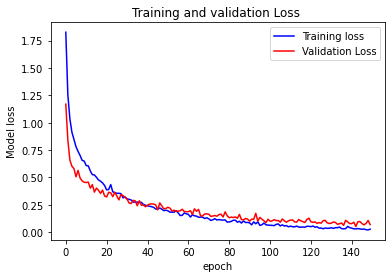

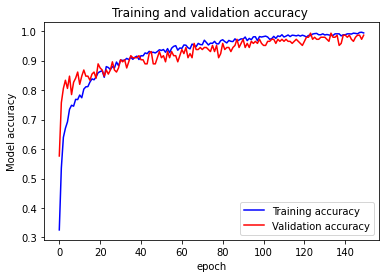

In [ ]:
      
#cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=100, validation_data=(x_testcnn, y_test))

fig=plt.figure();
plt.plot(history.history['loss'], label='Training loss',color='b')
plt.plot(history.history['val_loss'], label='Validation Loss',color='r')
plt.title('Training and validation Loss ')
plt.ylabel('Model loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
fig.savefig('1.png', format='png', dpi=1200)

fig1=plt.figure();
plt.plot(history.history['accuracy'], label='Training accuracy',color='b')
plt.plot(history.history['val_accuracy'], label='Validation accuracy',color='r')
plt.title('Training and validation accuracy ')
plt.ylabel('Model accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

fig1.savefig('1.png', format='png', dpi=1200)